In [ ]:
from google.colab import files


In [44]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #mean and standard deviation pulled from ImageNet dataset
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
data_dir = "/content/stanford-dogs/images/Images"
full_dataset = ImageFolder(root=data_dir, transform=train_transforms)
train_size = int(0.8*len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])
val_set.dataset.transform = val_transforms

In [ ]:
#defining data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)
#shuffle does not matter in validation

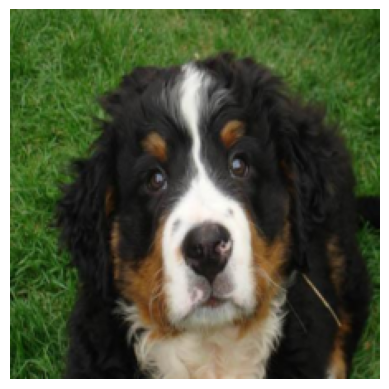

Rasa: n02107683-Bernese_mountain_dog


In [45]:
#printing dog photo
import matplotlib.pyplot as plt

def show_image(tensor):
    img = tensor.permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

images, labels = next(iter(train_loader))
show_image(images[0])
print(f"Rasa: {full_dataset.classes[labels[0]]}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

#Model
class DogBreedClassifier(nn.Module):
    def __init__(self, num_classes=120):
        super(DogBreedClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

#CUDA on NVIDIA GPU only
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DogBreedClassifier(num_classes=120).to(device)
criterion = nn.CrossEntropyLoss()
#CUDA optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)